# Feature Selection & Dimensionality Reduction Deep Dive

This notebook provides a detailed guide to the feature engineering capabilities of the `ML_Engine` library using the sample dataset `ds_sample.csv`. We will explore:

1.  **Setup**: Loading the real dataset.
2.  **Config-Driven Experiment**: Using `run_feature_selection_experiment` to compare multiple methods at once.
3.  **Manual Methods**:
    - Variance Threshold
    - K-Best Features
    - Recursive Feature Elimination (RFE)
    - Boruta
4.  **Dimensionality Reduction**:
    - Principal Component Analysis (PCA)
    - t-SNE for visualization

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import os
from ML_Engine.features import selection, reduction
from ML_Engine.utils.logger import get_logger
import matplotlib.pyplot as plt

logger = get_logger(__name__)

# --- WORKAROUND: Manually load model configs to prevent empty results ---
try:
    from ML_Engine.models import configs
    import yaml
    config_path = os.path.join(base_dir, 'configs', 'model_defaults.yml')
    
    if os.path.exists(config_path) and not configs._MODEL_CONFIGS:
        print(f"Manually loading model configs from: {config_path}")
        with open(config_path, 'r') as f:
            yaml_configs = yaml.safe_load(f)
        
        for problem_type, models in yaml_configs.items():
            for model_name, config in models.items():
                if model_name in configs.MODEL_CLASS_MAP:
                    config['class'] = configs.MODEL_CLASS_MAP[model_name]
        
        configs._MODEL_CONFIGS = yaml_configs
        print("Model configs loaded successfully.")
except Exception as e:
    print(f"Warning: Could not manually load model configs: {e}")
# -----------------------------------------------------------------


# Load the real dataset
data_path = os.path.join('dataset', 'adult_census_sample.csv')
full_df = pd.read_csv(data_path)

# Define target and features to drop
target_col = 'income'
drop_cols = ['income']  # Keep all other features for feature selection

# Prepare X and y
X_df = full_df.drop(columns=drop_cols)
y_s = full_df[target_col]

logger.info(f"Dataset loaded with shape: {X_df.shape}")

# --- Helper to find configs ---
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
fs_config_path = os.path.join(base_dir, 'configs', 'feature_selection_experiments.yml')

2026-02-10 22:06:59,533 - __main__ - INFO - Dataset loaded with shape: (5000, 14)


## 2. Config-Driven Experiment

The most efficient way to compare multiple feature selection methods is to run an experiment defined in `configs/feature_selection_experiments.yml`.

In [2]:
experiment_results = selection.run_feature_selection_experiment(
    experiment_name='default_comparison',
    X=X_df,
    y=y_s,
    problem_type='Classification',
    config_path=fs_config_path if os.path.exists(fs_config_path) else None
)

for method, features in experiment_results.items():
    print(f"Method: {method}\nSelected {len(features)} features: {features}\n")

2026-02-10 22:06:59,553 - ML_Engine.features.selection - INFO - Running feature selection experiment: A standard comparison of Variance, K-Best, and RFE methods.
2026-02-10 22:06:59,553 - ML_Engine.features.selection - INFO - Running method: variance with params: {'threshold': 0.01}
2026-02-10 22:06:59,571 - ML_Engine.features.selection - INFO - Running method: kbest with params: {'k': 10, 'score_func': 'f_classif'}
2026-02-10 22:06:59,583 - ML_Engine.features.selection - INFO - Running method: rfe with params: {'estimator': 'RandomForestClassifier', 'n_features_to_select': 15, 'step': 1}
Method: variance
Selected 14 features: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

Method: kbest
Selected 10 features: ['age', 'education', 'education-num', 'marital-status', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week']

## 3. Manual Methods

You can also run each method individually for more granular control.

### Variance Threshold

In [3]:
variance_indices = selection.variance_feature_selection(X_df, threshold=0.01)
selected_features_variance = X_df.columns[variance_indices].tolist()
logger.info(f"Variance Threshold selected {len(selected_features_variance)} features.")

2026-02-10 22:07:00,055 - __main__ - INFO - Variance Threshold selected 14 features.


### K-Best Features

In [4]:
kbest_indices, scores = selection.select_k_best_features(
    X_df, y_s, k=15, score_func='f_classif', problem_type='Classification'
)
selected_features_kbest = X_df.columns[kbest_indices].tolist()
logger.info(f"SelectKBest selected {len(selected_features_kbest)} features.")

2026-02-10 22:07:00,100 - __main__ - INFO - SelectKBest selected 14 features.


### Recursive Feature Elimination (RFE)

In [5]:
from sklearn.ensemble import RandomForestClassifier

rfe_indices, rankings = selection.recursive_feature_elimination(
    X_df, y_s, 
    estimator=RandomForestClassifier(n_estimators=50, random_state=42),
    n_features_to_select=15,
    problem_type='Classification'
)
selected_features_rfe = X_df.columns[rfe_indices].tolist()
logger.info(f"RFE selected {len(selected_features_rfe)} features.")

2026-02-10 22:07:00,363 - __main__ - INFO - RFE selected 14 features.


### Boruta

In [6]:
try:
    boruta_mask, _ = selection.boruta_feature_selection(
        X_df, y_s, problem_type='Classification', max_iter=50, random_state=42
    )
    selected_features_boruta = X_df.columns[boruta_mask].tolist()
    logger.info(f"Boruta selected {len(selected_features_boruta)} features.")
except ImportError as e:
    logger.error(f"Could not run Boruta: {e}")

2026-02-10 22:07:07,241 - __main__ - INFO - Boruta selected 4 features.


## 4. Dimensionality Reduction

### Principal Component Analysis (PCA)

In [7]:
X_pca, pca_model = reduction.apply_pca(X_df, variance=0.95)
logger.info(f"PCA reduced the data from {X_df.shape[1]} features to {X_pca.shape[1]} components.")

2026-02-10 22:07:07,288 - __main__ - INFO - PCA reduced the data from 14 features to 1 components.


### t-SNE (for Visualization)

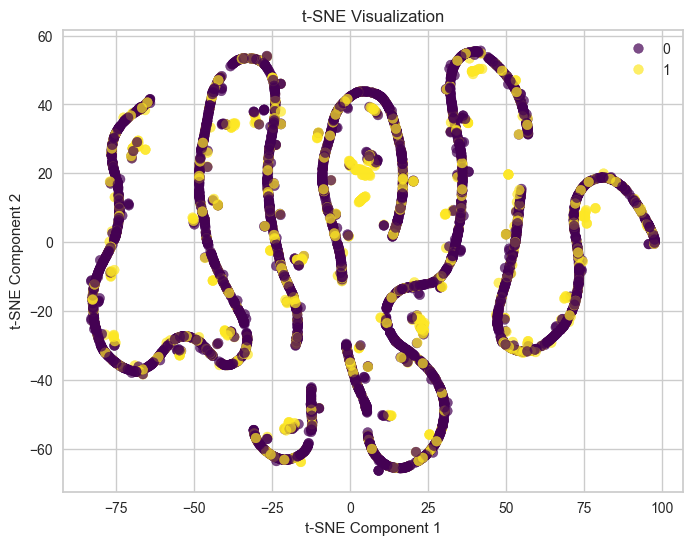

Plot saved to: outputs\02_Feature_Selection_Deep_Dive\tsne_visualization.png


<Figure size 800x550 with 0 Axes>

In [8]:
# Encode target for visualization
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_s)

X_tsne, _ = reduction.apply_tsne(X_df, n_components=2, perplexity=30, random_state=42)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.7)
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=le.classes_.tolist())
plt.show()
# Save the plot
output_dir = os.path.join('outputs', '02_Feature_Selection_Deep_Dive')
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, 'tsne_visualization.png')
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
print(f"Plot saved to: {plot_path}")

